In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.neural_network import MLPClassifier
from classification_utils import *
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.constraints import MaxNorm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import statistics
import pickle

In [42]:
data = pd.read_csv("dataset/cleaned_user_profiles.csv", index_col=0)

In [43]:
data.head()

,name,lang,bot,created_at,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std
2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,62.340909,14.015152,0.000000,0.272727,0.098485,0.0,0.0,0.037879,0.190903,0.232481,0.037879,0.190903
2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,69.082645,15.041322,0.000000,0.338843,0.024793,0.0,0.0,0.049587,0.217090,0.284639,0.024793,0.155495
137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,53,65.340909,14.694444,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,86.944871,18.689463,0.022331,0.006281,0.072575,0.0,0.0,0.165387,0.530838,0.669155,0.826239,13.034008
2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,72.311246,14.582073,0.000825,0.506461,0.118229,0.0,0.0,0.056365,0.243387,0.317182,0.016772,0.142619


In [44]:
data.describe()

,bot,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std
count,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000
mean,0.531456,5148.794751,67.100135,15.045892,0.031045,0.329076,0.088484,0.001967,0.023941,0.084281,0.365536,0.385427,1.357545,14.574041
std,0.499031,18496.606420,12.755296,2.454106,0.053379,0.315589,0.070828,0.007796,0.068508,0.109621,0.408358,0.390777,2.827068,23.390000
min,0.000000,0.000000,32.500000,9.644166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,53.000000,59.686796,13.553296,0.000000,0.010260,0.045455,0.000000,0.000000,0.017751,0.136692,0.119116,0.010526,0.104251
50%,1.000000,57.000000,65.340909,14.694444,0.005109,0.300971,0.070423,0.000000,0.000000,0.045752,0.230747,0.268594,0.043478,0.238606
75%,1.000000,2041.000000,74.254999,16.772205,0.037445,0.450781,0.113295,0.000000,0.000000,0.088862,0.451218,0.491767,0.949402,24.144412
max,1.000000,399555.000000,104.449541,22.000000,0.287760,1.210354,0.337268,0.044444,0.333767,0.529903,2.183383,1.723913,12.902439,198.461303


In [45]:
data.isnull().values.any()

False

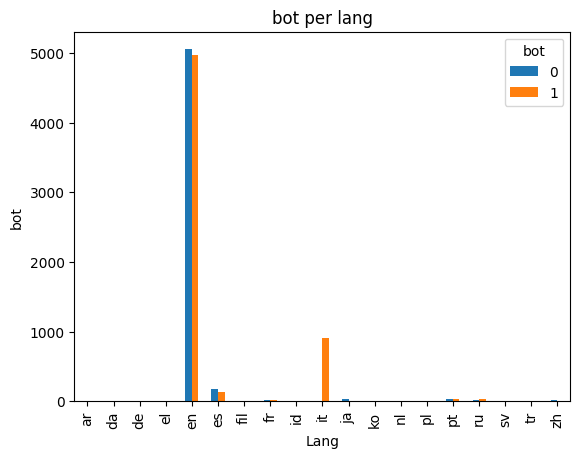

In [46]:
plot_lang_hist(data)

In [47]:
data = data.join(pd.get_dummies(data["lang"]))

In [48]:
#data.drop(columns=['created_at'])

In [49]:
train_set, test_set, train_label, test_label = prepare_data(data)

Classification features : ['created_at', 'statuses_count', 'avg_length', 'avg_special_chars', 'urls_ratio', 'mentions_ratio', 'hashtags_ratio', 'reply_count_mean', 'reply_count_std', 'favorite_count_mean', 'favorite_count_std', 'favorite_count_entropy', 'retweet_count_mean', 'retweet_count_std', 'ar', 'da', 'de', 'el', 'en', 'es', 'fil', 'fr', 'id', 'it', 'ja', 'ko', 'nl', 'pl', 'pt', 'ru', 'sv', 'tr', 'zh']


In [50]:
scaler = StandardScaler()
scaled_train_set = scaler.fit_transform(train_set.values)
scaled_test_set = scaler.transform(test_set.values)

In [51]:
seed = 7
tf.random.set_seed(seed)

model = KerasClassifier(model=create_model, loss="binary_crossentropy", verbose=0, epochs=10)

param_grid = dict(
    hidden_layer_sizes = [[16, 8], [32, 16, 8]],
    learning_rate_init = [0.001, 0.01, 0.1],
    momentum = [0.1, 0.5, 0.8]
)

print(param_grid)

grid = GridSearchCV(
    MLPClassifier(random_state = 8, activation='relu', max_iter = 250),
    param_grid = param_grid,
    cv = 3,
    scoring = 'accuracy',
    verbose = 4
)

grid_result = grid.fit(scaled_train_set, train_label)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

{'hidden_layer_sizes': [[16, 8], [32, 16, 8]], 'learning_rate_init': [0.001, 0.01, 0.1], 'momentum': [0.1, 0.5, 0.8]}
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.001, momentum=0.1;, score=0.839 total time=   2.7s
[CV 2/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.001, momentum=0.1;, score=0.835 total time=   2.1s
[CV 3/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.001, momentum=0.1;, score=0.836 total time=   1.8s


/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.001, momentum=0.5;, score=0.839 total time=   2.2s
[CV 2/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.001, momentum=0.5;, score=0.835 total time=   2.3s
[CV 3/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.001, momentum=0.5;, score=0.836 total time=   1.7s


/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.001, momentum=0.8;, score=0.839 total time=   2.2s
[CV 2/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.001, momentum=0.8;, score=0.835 total time=   2.1s
[CV 3/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.001, momentum=0.8;, score=0.836 total time=   2.0s
[CV 1/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.01, momentum=0.1;, score=0.826 total time=   1.1s
[CV 2/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.01, momentum=0.1;, score=0.833 total time=   1.1s
[CV 3/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.01, momentum=0.1;, score=0.833 total time=   0.9s
[CV 1/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.01, momentum=0.5;, score=0.826 total time=   1.0s
[CV 2/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.01, momentum=0.5;, score=0.833 total time=   1.3s
[CV 3/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.01, momentum=0.5;, score=0.833 total ti

In [52]:
nn = grid.best_estimator_

In [53]:
train_pred = nn.predict(scaled_train_set)
test_pred = nn.predict(scaled_test_set)

In [54]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8594661700806953
Accuracy test set  0.8386909933391254
Precision train set  0.879897323291793
Recall train set  0.8594661700806953
F1 score train set  0.8562775620987273
Support train set  (array([0.9704416 , 0.80007623]), array([0.72204557, 0.98061201]), array([0.8280158 , 0.88119228]), array([3774, 4281]))


In [55]:
#compute the performance of the model
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

        <=50       0.94      0.70      0.80      1618
         >50       0.78      0.96      0.86      1835

    accuracy                           0.84      3453
   macro avg       0.86      0.83      0.83      3453
weighted avg       0.86      0.84      0.83      3453



/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


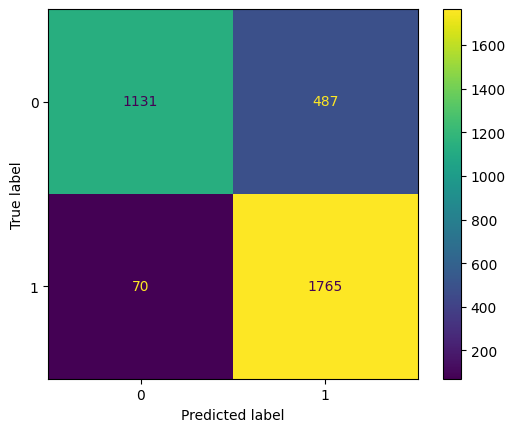

In [56]:
plot_confusion_matrix(nn, scaled_test_set, test_label)
plt.show()

In [57]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(scaled_test_set)

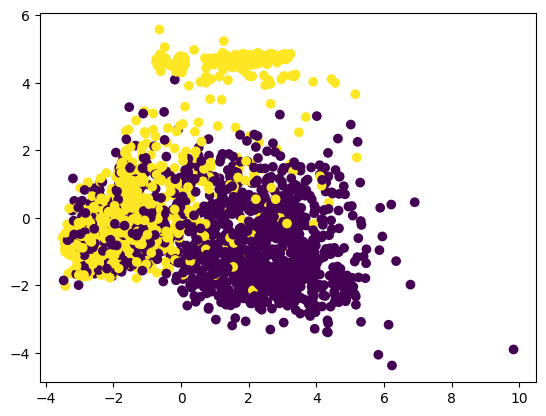

In [58]:
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label);

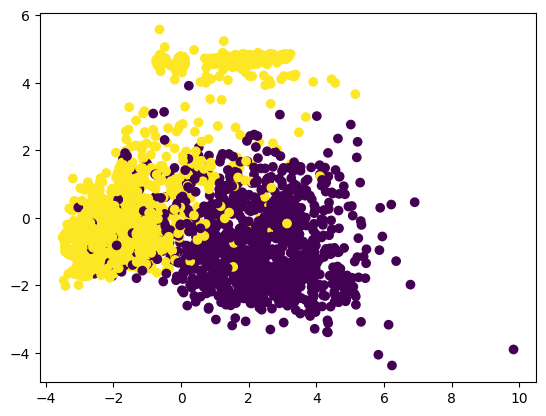

In [59]:
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred);

In [62]:
with open("models_checkpoints/nn_lang.bin", "wb") as f:
    pickle.dump(nn, f)

### Without lang

In [63]:
for lang in data.lang.unique():
    del train_set[lang]
    del test_set[lang]

In [65]:
train_set.head()

,created_at,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std
2381324954,1552354916,43,57.276190,12.590476,0.000000,0.342857,0.057143,0.0,0.0,0.123810,0.382852,0.555572,0.038095,0.235991
2381124445,1552343606,36,62.577778,13.711111,0.000000,0.311111,0.077778,0.0,0.0,0.100000,0.300000,0.468996,0.033333,0.179505
2384265157,1552514996,46,64.223301,14.466019,0.000000,0.291262,0.058252,0.0,0.0,0.048544,0.214912,0.280178,0.058252,0.272537
441497987,1482295018,15121,62.669565,13.223098,0.089130,0.864674,0.048641,0.0,0.0,0.327717,0.842933,1.037589,7.890761,41.902884
466452520,1484742482,121,86.334868,18.563816,0.015132,0.006579,0.065132,0.0,0.0,0.045752,1.219106,1.627111,0.763816,5.338922


In [66]:
scaler = StandardScaler()

scaled_train_set = scaler.fit_transform(train_set.values)
scaled_test_set = scaler.transform(test_set.values)

In [67]:
seed = 7
tf.random.set_seed(seed)

model = KerasClassifier(model=create_model, loss="binary_crossentropy", verbose=0, epochs=10)

param_grid = dict(
    hidden_layer_sizes = [[16, 8], [32, 16, 8]],
    learning_rate_init = [0.001, 0.01, 0.1],
    momentum = [0.1, 0.5, 0.8]
)

print(param_grid)

grid = GridSearchCV(
    MLPClassifier(random_state = 8, activation='relu', max_iter = 250),
    param_grid = param_grid,
    cv = 3,
    scoring = 'accuracy',
    verbose = 4
)

grid_result = grid.fit(scaled_train_set, train_label)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

{'hidden_layer_sizes': [[16, 8], [32, 16, 8]], 'learning_rate_init': [0.001, 0.01, 0.1], 'momentum': [0.1, 0.5, 0.8]}
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.001, momentum=0.1;, score=0.841 total time=   2.5s


/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.001, momentum=0.1;, score=0.835 total time=   2.4s


/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.001, momentum=0.1;, score=0.847 total time=   2.5s


/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.001, momentum=0.5;, score=0.841 total time=   2.5s


/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.001, momentum=0.5;, score=0.835 total time=   2.8s


/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.001, momentum=0.5;, score=0.847 total time=   2.7s


/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.001, momentum=0.8;, score=0.841 total time=   2.5s


/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.001, momentum=0.8;, score=0.835 total time=   2.2s


/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.001, momentum=0.8;, score=0.847 total time=   2.3s
[CV 1/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.01, momentum=0.1;, score=0.838 total time=   0.9s
[CV 2/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.01, momentum=0.1;, score=0.838 total time=   1.2s
[CV 3/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.01, momentum=0.1;, score=0.834 total time=   1.5s
[CV 1/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.01, momentum=0.5;, score=0.838 total time=   1.0s
[CV 2/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.01, momentum=0.5;, score=0.838 total time=   1.4s
[CV 3/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.01, momentum=0.5;, score=0.834 total time=   1.5s
[CV 1/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.01, momentum=0.8;, score=0.838 total time=   1.0s
[CV 2/3] END hidden_layer_sizes=[16, 8], learning_rate_init=0.01, momentum=0.8;, score=0.838 total time

/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


In [68]:
nn = grid.best_estimator_

In [69]:
train_pred = nn.predict(scaled_train_set)
test_pred = nn.predict(scaled_test_set)

In [70]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8612042209807573
Accuracy test set  0.8389805965826818
Precision train set  0.8827556116582471
Recall train set  0.8612042209807573
F1 score train set  0.857943119263882
Support train set  (array([0.97632712, 0.80026581]), array([0.72125066, 0.98458304]), array([0.82962511, 0.88290742]), array([3774, 4281]))


In [71]:
#compute the performance of the model
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

        <=50       0.94      0.70      0.80      1618
         >50       0.78      0.96      0.86      1835

    accuracy                           0.84      3453
   macro avg       0.86      0.83      0.83      3453
weighted avg       0.86      0.84      0.84      3453



/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


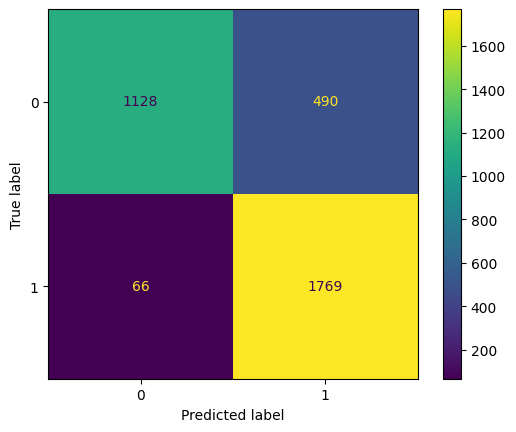

In [72]:
plot_confusion_matrix(nn, scaled_test_set, test_label)
plt.show()

In [73]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(scaled_test_set)

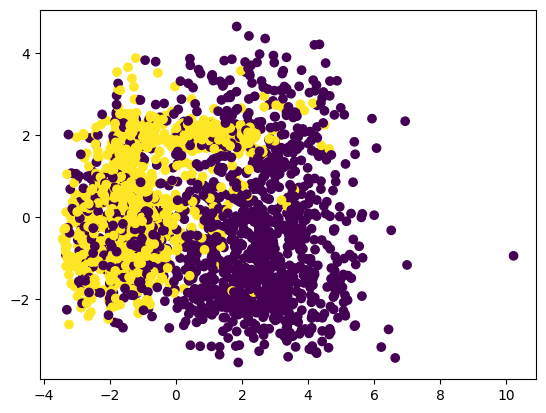

In [74]:
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label);

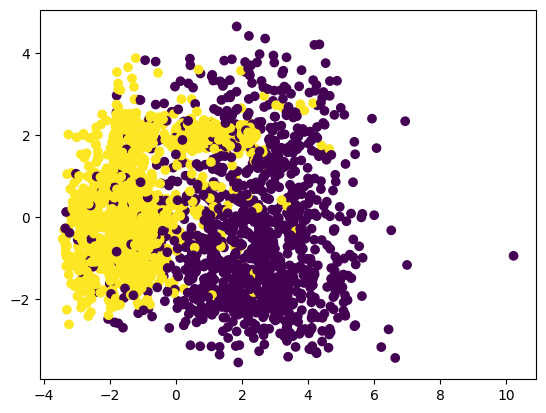

In [75]:
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred);

In [77]:
with open("models_checkpoints/nn_no_lang.bin", "wb") as f:
    pickle.dump(nn, f)